Items to address:
1. IoU basic stats (mean, sd) by each group:
    
    a. Trial
    
    b. Size
    
    c. Species
2. Correlations for each of the above groups
3. Regression plots for each of the above groups

In [46]:
import numpy as np
import pandas as pd
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import kruskal
import scikit_posthocs as sp
import seaborn as sns

In [2]:
# Read in the data
idf = pd.read_csv('performance_test_iou.csv')
ddf = pd.read_csv('full_pc_directory.csv')
vdf = pd.read_csv('volume_directory.csv', usecols=['sample_id', 'convh_vol'])

In [3]:
# Merge dfs on sample_id
ddf = ddf[ddf['s_priority'] != 5]
idf = idf.rename(columns={'sample': 'sample_id'})
df = ddf.merge(idf, on='sample_id')
df = df.merge(vdf, on='sample_id', how='inner')


In [4]:
print(df.columns)

Index(['plot_id', 'date_dir', 'trial_dir', 'file_path', 'date', 'sample_id',
       'species', 'scan_level', 'plants_per_group', 'group_proportion',
       'bounding_width', 'bounding_depth', 'bounding_height', 'hue',
       'saturation', 'value', 'k_neighbors', 'n_std_ratio', 'k_s',
       's_std_ratio', 'problem', 'problem_type', 's_priority',
       'groundtruthed_total', 'processed_total', 'groundtruthed_plant_total',
       'groundtruthed_nonplant_total', 'processed_plant_total',
       'processed_nonplant_total', 'ppgpint', 'pngnint', 'ppgnint', 'pngpint',
       'punion', 'nunion', 'piou', 'niou', 'convh_vol'],
      dtype='object')


In [5]:
# Convert transplant-age plants to garden plots and the seedless and personal watermelon trials with one trial
df['trial_dir'] = df['trial_dir'].replace('Transplant-Age_Plants', 'Garden_Plots')
df['trial_dir'] = df['trial_dir'].replace(['Seedless_Watermelon_Variety_Trial', 'Personal-Sized_Watermelons'], 'Watermelon_Variety_Trial')

In [6]:
# Set up summary stats df
cols = 'subset', 'mean_iou', 'std_iou'
summary_df = pd.DataFrame(columns=cols)

In [7]:
# Add summary stats for each trial
for subset in df['trial_dir'].unique():
    subset_df = df[df['trial_dir'] == subset]
    mean_iou = np.mean(subset_df['piou'])
    std_iou = np.std(subset_df['piou'])
    summary_df = pd.concat([summary_df, pd.DataFrame([[subset, mean_iou, std_iou]], columns=cols)])

In [8]:
print(summary_df)

                     subset  mean_iou   std_iou
0              Garden_Plots  0.833895  0.146351
0   Tomato_Fertilizer_Trial  0.852967  0.083693
0  Watermelon_Variety_Trial  0.921142  0.044062
0      Pepper_Variety_Trial  0.932570  0.028834


In [9]:
# get quintiles for convh_vol
df['convh_vol'] = df['convh_vol'].astype(float)
df['convh_vol_quintile'] = pd.qcut(df['convh_vol'], 5, labels=False)
# print mean convh_vol for each quintile
print(df.groupby('convh_vol_quintile')['convh_vol'].mean())
# print mean iou for each quintile
print(df.groupby('convh_vol_quintile')['piou'].mean())
# print sd iou for each quintile
print(df.groupby('convh_vol_quintile')['piou'].std())

convh_vol_quintile
0    0.041833
1    0.300172
2    0.611283
3    1.145840
4    3.584379
Name: convh_vol, dtype: float64
convh_vol_quintile
0    0.825170
1    0.885397
2    0.886465
3    0.913154
4    0.919253
Name: piou, dtype: float64
convh_vol_quintile
0    0.175599
1    0.075475
2    0.063187
3    0.040799
4    0.037253
Name: piou, dtype: float64


In [10]:
# Get min and max for each quintile
mins = list(df.groupby('convh_vol_quintile')['convh_vol'].min().round(3))
maxs = list(df.groupby('convh_vol_quintile')['convh_vol'].max().round(3))
print(mins)
print(maxs)

[0.0, 0.088, 0.488, 0.778, 1.421]
[0.083, 0.487, 0.768, 1.415, 17.961]


In [11]:
# Create list of quintile ranges
quintile_ranges = []
quints = ['0-20%', '20-40%', '40-60%', '60-80%', '80-100%']
for i in range(len(mins)):
    quintile_ranges.append(quints[i] + ': ' + str(mins[i]) + '-' + str(maxs[i]))
print(quintile_ranges)

['0-20%: 0.0-0.083', '20-40%: 0.088-0.487', '40-60%: 0.488-0.768', '60-80%: 0.778-1.415', '80-100%: 1.421-17.961']


In [12]:
# Rename df quintiles with quintile ranges
df['convh_vol_quintile'] = df['convh_vol_quintile'].replace([0, 1, 2, 3, 4], quintile_ranges)

In [13]:
# Add summary stats for each quintile
for quint in df['convh_vol_quintile'].unique():
    quint_df = df[df['convh_vol_quintile'] == quint]
    mean_iou = np.mean(quint_df['piou'])
    std_iou = np.std(quint_df['piou'])
    summary_df = pd.concat([summary_df, pd.DataFrame([[quint, mean_iou, std_iou]], columns=cols)])

In [14]:
print(summary_df)

                     subset  mean_iou   std_iou
0              Garden_Plots  0.833895  0.146351
0   Tomato_Fertilizer_Trial  0.852967  0.083693
0  Watermelon_Variety_Trial  0.921142  0.044062
0      Pepper_Variety_Trial  0.932570  0.028834
0          0-20%: 0.0-0.083  0.825170  0.174104
0       60-80%: 0.778-1.415  0.913154  0.040451
0     80-100%: 1.421-17.961  0.919253  0.036936
0       20-40%: 0.088-0.487  0.885397  0.074833
0       40-60%: 0.488-0.768  0.886465  0.062650


In [15]:
# Add summary stats for each species
for species in df['species'].unique():
    species_df = df[df['species'] == species]
    mean_iou = np.mean(species_df['piou'])
    std_iou = np.std(species_df['piou'])
    summary_df = pd.concat([summary_df, pd.DataFrame([[species, mean_iou, std_iou]], columns=cols)])

In [16]:
print(summary_df)

                     subset  mean_iou   std_iou
0              Garden_Plots  0.833895  0.146351
0   Tomato_Fertilizer_Trial  0.852967  0.083693
0  Watermelon_Variety_Trial  0.921142  0.044062
0      Pepper_Variety_Trial  0.932570  0.028834
0          0-20%: 0.0-0.083  0.825170  0.174104
0       60-80%: 0.778-1.415  0.913154  0.040451
0     80-100%: 1.421-17.961  0.919253  0.036936
0       20-40%: 0.088-0.487  0.885397  0.074833
0       40-60%: 0.488-0.768  0.886465  0.062650
0                watermelon  0.855194  0.142674
0                    tomato  0.863254  0.092594
0                    pepper  0.932570  0.028834


In [17]:
# Add summary stats for total
mean_iou = np.mean(df['piou'])
std_iou = np.std(df['piou'])
summary_df = pd.concat([summary_df, pd.DataFrame([['total', mean_iou, std_iou]], columns=cols)])

In [18]:
print(summary_df)

                     subset  mean_iou   std_iou
0              Garden_Plots  0.833895  0.146351
0   Tomato_Fertilizer_Trial  0.852967  0.083693
0  Watermelon_Variety_Trial  0.921142  0.044062
0      Pepper_Variety_Trial  0.932570  0.028834
0          0-20%: 0.0-0.083  0.825170  0.174104
0       60-80%: 0.778-1.415  0.913154  0.040451
0     80-100%: 1.421-17.961  0.919253  0.036936
0       20-40%: 0.088-0.487  0.885397  0.074833
0       40-60%: 0.488-0.768  0.886465  0.062650
0                watermelon  0.855194  0.142674
0                    tomato  0.863254  0.092594
0                    pepper  0.932570  0.028834
0                     total  0.885888  0.098368


In [19]:
summary_df.to_csv('iou_summary.csv', index=False)

Correlations

In [20]:
# Spearman correlation between trial and iou
trial_iou_corr, _ = spearmanr(df['trial_dir'], df['piou'])
print('Trial and iou correlation: %.3f' % trial_iou_corr)
# print p values
print('p value: %.3f' % _)
# No correlation between trial and iou

Trial and iou correlation: 0.062
p value: 0.287


In [21]:
# Pearson correlation between convh_vol and iou
convh_vol_iou_corr, _ = pearsonr(df['convh_vol'], df['piou'])
print('Convh_vol and iou correlation: %.3f' % convh_vol_iou_corr)
# print p values
print('p value: %.3f' % _)
# Correlation between convh_vol and iou

Convh_vol and iou correlation: 0.155
p value: 0.008


In [22]:
# Spearman correlation between species and iou
species_iou_corr, _ = spearmanr(df['species'], df['piou'])
print('Species and iou correlation: %.3f' % species_iou_corr)
# print p values
print('p value: %.3f' % _)
# Correlation between species and iou

Species and iou correlation: -0.314
p value: 0.000


Regression

In [23]:
# Set test and train splits
random.seed(42)
train_size = 0.8
test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(df['convh_vol'], df['piou'], train_size=train_size, test_size=test_size)

In [24]:
# Create regression equations
def linear(x, a, b):
    return a*x + b

def exponential(x, a, b, c):
    return a*np.exp(-b*x) + c

def power(x, a, b, c):
    return a*x**b + c

def log(x, a, b, c):
    return a*np.log(b*x + 1) + c

def poly2deg(x, a, b, c):
    return a*x**2 + b*x + c

In [25]:
# Fit regression equations
rdf = pd.DataFrame(columns=['model', 'params', 'r2', 'rmse'])
for model in [linear, exponential, power, log, poly2deg]:
    popt, _ = curve_fit(model, X_train, y_train)
    y_pred = model(X_test, *popt)
    r2 = r2_score(y_test, y_pred)
    rmse = np.sqrt(np.mean((y_test - y_pred)**2))
    rdf = pd.concat([rdf, pd.DataFrame([[model.__name__, popt, r2, rmse]], columns=['model', 'params', 'r2', 'rmse'])])

c:\Users\Steven\anaconda3\envs\pcp_env\lib\site-packages\pandas\core\arraylike.py:396: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [26]:
print(rdf)

         model                                             params        r2  \
0       linear         [0.006141641232562334, 0.8782426797586251]  0.032753   
0  exponential  [-0.30890980239787585, 39.47935497176454, 0.90...  0.134217   
0        power  [1115.9525743140925, 2.3557882571289677e-05, -...  0.107968   
0          log  [0.02629173048418191, 8886537.879079714, 0.488...  0.107951   
0     poly2deg  [-0.001972265316545185, 0.035653383028743504, ...  0.060491   

       rmse  
0  0.087964  
0  0.083222  
0  0.084474  
0  0.084475  
0  0.086693  


None are particularly good. This suggests that although there is some correlation, there is no relationship that can be described in a linear (or nonlinear, continuous) sense.

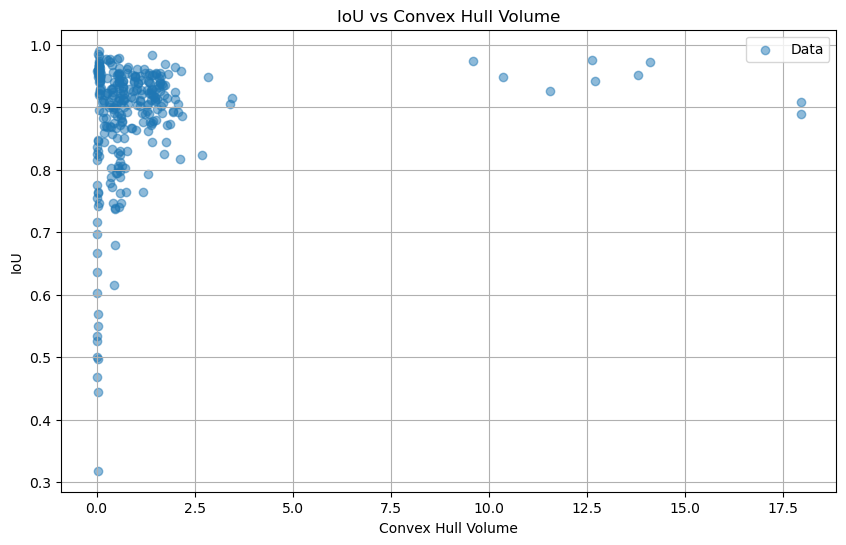

In [27]:
# plot iou vs convh_vol
plt.figure(figsize=(10, 6))
plt.scatter(df['convh_vol'], df['piou'], alpha=0.5, label='Data')
plt.xlabel('Convex Hull Volume')
plt.ylabel('IoU')
plt.title('IoU vs Convex Hull Volume')
plt.legend()
plt.grid()
plt.show()

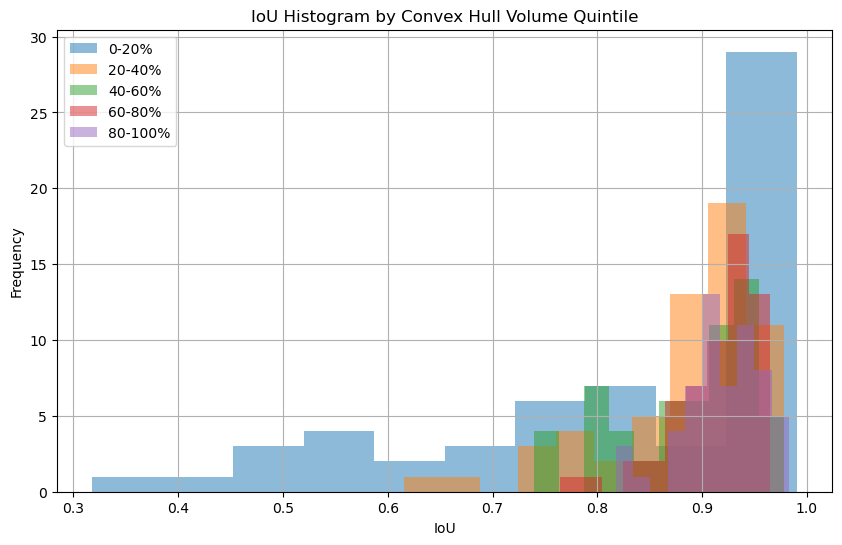

In [28]:
# Make histogram of iou for each quintile
plt.figure(figsize=(10, 6))
quint1 = df[df['convh_vol_quintile'] == '0-20%: 0.0-0.083']
quint2 = df[df['convh_vol_quintile'] == '20-40%: 0.088-0.487']
quint3 = df[df['convh_vol_quintile'] == '40-60%: 0.488-0.768']
quint4 = df[df['convh_vol_quintile'] == '60-80%: 0.778-1.415']
quint5 = df[df['convh_vol_quintile'] == '80-100%: 1.421-17.961']
plt.hist(quint1['piou'], alpha=0.5, label='0-20%')
plt.hist(quint2['piou'], alpha=0.5, label='20-40%')
plt.hist(quint3['piou'], alpha=0.5, label='40-60%')
plt.hist(quint4['piou'], alpha=0.5, label='60-80%')
plt.hist(quint5['piou'], alpha=0.5, label='80-100%')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('IoU Histogram by Convex Hull Volume Quintile')
plt.legend()
plt.grid()
plt.show()

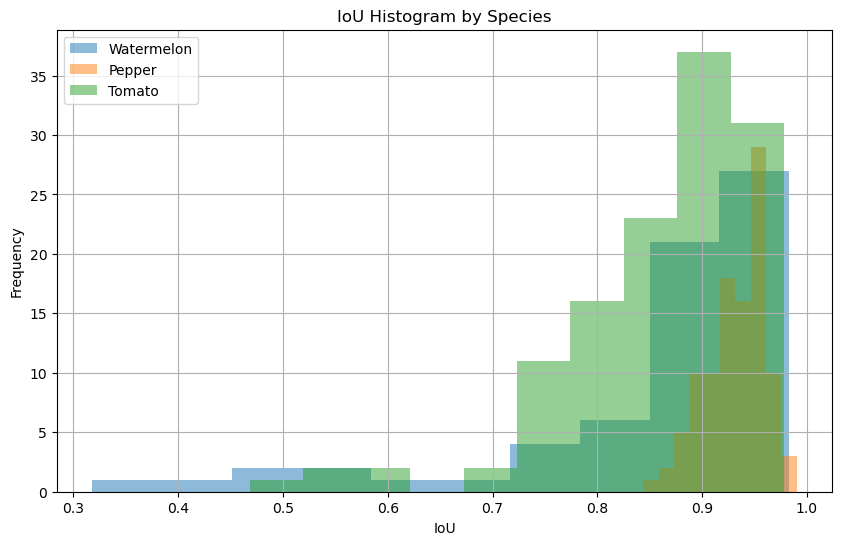

In [29]:
# Plot histogram of iou for each species
plt.figure(figsize=(10, 6))
wdf = df[df['species'] == 'watermelon']
pdf = df[df['species'] == 'pepper']
tdf = df[df['species'] == 'tomato']
plt.hist(wdf['piou'], alpha=0.5, label='Watermelon')
plt.hist(pdf['piou'], alpha=0.5, label='Pepper')
plt.hist(tdf['piou'], alpha=0.5, label='Tomato')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('IoU Histogram by Species')
plt.legend()
plt.grid()
plt.show()

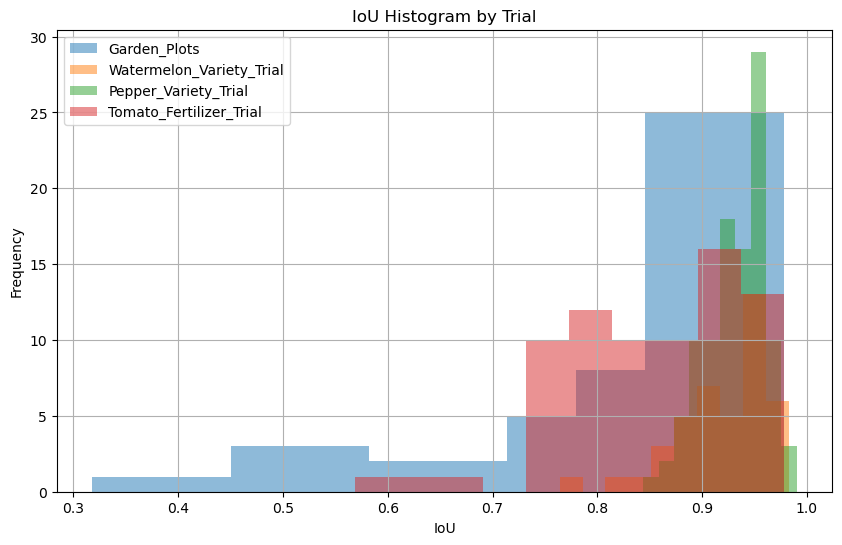

In [30]:
# Plot histogram of iou for each trial
plt.figure(figsize=(10, 6))
gpdf = df[df['trial_dir'] == 'Garden_Plots']
wvtf = df[df['trial_dir'] == 'Watermelon_Variety_Trial']
pvdf = df[df['trial_dir'] == 'Pepper_Variety_Trial']
tfdf = df[df['trial_dir'] == 'Tomato_Fertilizer_Trial']
plt.hist(gpdf['piou'], alpha=0.5, label='Garden_Plots')
plt.hist(wvtf['piou'], alpha=0.5, label='Watermelon_Variety_Trial')
plt.hist(pvdf['piou'], alpha=0.5, label='Pepper_Variety_Trial')
plt.hist(tfdf['piou'], alpha=0.5, label='Tomato_Fertilizer_Trial')
plt.xlabel('IoU')
plt.ylabel('Frequency')
plt.title('IoU Histogram by Trial')
plt.legend()
plt.grid()
plt.show()

# Testing Differences Between Groups
First, we must see if ANOVA testing is possible through examination of distribution normality and equal variances.

In [31]:
# Run shapiro-wilk test for normality for each quintile
for quint in df['convh_vol_quintile'].unique():
	quint_df = df[df['convh_vol_quintile'] == quint]
	stat, p = stats.shapiro(quint_df['piou'])
	print('Shapiro-Wilk test for %s: stat=%.3f, p=%.3f' % (quint, stat, p))
	# interpret
	alpha = 0.05
	if p > alpha:
		print('Sample looks Gaussian (fail to reject H0)')
	else:
		print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk test for 0-20%: 0.0-0.083: stat=0.817, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for 60-80%: 0.778-1.415: stat=0.881, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for 80-100%: 1.421-17.961: stat=0.950, p=0.016
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for 20-40%: 0.088-0.487: stat=0.866, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for 40-60%: 0.488-0.768: stat=0.923, p=0.001
Sample does not look Gaussian (reject H0)


In [32]:
# Run Shapiro-Wilk test for normality for each species
for species in df['species'].unique():
	species_df = df[df['species'] == species]
	stat, p = stats.shapiro(species_df['piou'])
	print('Shapiro-Wilk test for %s: stat=%.3f, p=%.3f' % (species, stat, p))
	# interpret
	alpha = 0.05
	if p > alpha:
		print('Sample looks Gaussian (fail to reject H0)')
	else:
		print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk test for watermelon: stat=0.728, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for tomato: stat=0.871, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for pepper: stat=0.967, p=0.011
Sample does not look Gaussian (reject H0)


In [33]:
# Run Shapiro-Wilk test for normality for each species
for species in df['species'].unique():
	species_df = df[df['species'] == species]
	stat, p = stats.shapiro(species_df['piou'])
	print('Shapiro-Wilk test for %s: stat=%.3f, p=%.3f' % (species, stat, p))
	# interpret
	alpha = 0.05
	if p > alpha:
		print('Sample looks Gaussian (fail to reject H0)')
	else:
		print('Sample does not look Gaussian (reject H0)')

Shapiro-Wilk test for watermelon: stat=0.728, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for tomato: stat=0.871, p=0.000
Sample does not look Gaussian (reject H0)
Shapiro-Wilk test for pepper: stat=0.967, p=0.011
Sample does not look Gaussian (reject H0)


In [34]:
# Run levene's test for equal variance for each quintile
# Get list of all the quintile groups
grouped_data = [df[df['convh_vol_quintile'] == q]['piou'] for q in df['convh_vol_quintile'].unique()]

# Run Levene's test across all groups
stat, p = stats.levene(*grouped_data)
print(f"Levene’s test: stat={stat:.3f}, p={p:.3f}")

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Variances look equal (fail to reject H0)')
else:
    print('Variances differ significantly (reject H0)')

Levene’s test: stat=19.576, p=0.000
Variances differ significantly (reject H0)


In [35]:
# Run levene's test for equal variance for each species
# Get list of all the species groups
grouped_data = [df[df['species'] == s]['piou'] for s in df['species'].unique()]
# Run Levene's test across all groups
stat, p = stats.levene(*grouped_data)
print(f"Levene’s test: stat={stat:.3f}, p={p:.3f}")

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Variances look equal (fail to reject H0)')
else:
    print('Variances differ significantly (reject H0)')

Levene’s test: stat=16.834, p=0.000
Variances differ significantly (reject H0)


In [36]:
# Run levene's test for equal variance for each trial
# Get list of all the trial groups
grouped_data = [df[df['trial_dir'] == t]['piou'] for t in df['trial_dir'].unique()]
# Run Levene's test across all groups
stat, p = stats.levene(*grouped_data)
print(f"Levene’s test: stat={stat:.3f}, p={p:.3f}")

# Interpret the result
alpha = 0.05
if p > alpha:
    print('Variances look equal (fail to reject H0)')
else:
    print('Variances differ significantly (reject H0)')

Levene’s test: stat=17.955, p=0.000
Variances differ significantly (reject H0)


Summary: all groups have non-normal distributions and have unequal variances. A Kruskal-Wallis H-test will be done instead.

In [47]:
# Run a Kruskal-Wallis test for each quintile
# Get list of all the quintile groups
grouped_data = [df[df['convh_vol_quintile'] == q]['piou'] for q in df['convh_vol_quintile'].unique()]
# Run Kruskal-Wallis test across all groups
stat, p = stats.kruskal(*grouped_data)
print(f"Kruskal-Wallis test: stat={stat:.3f}, p={p:.3f}")
if p < 0.05:
    print("Significant differences between groups (reject H0)")
else:
    print("No significant differences (fail to reject H0)")

Kruskal-Wallis test: stat=8.178, p=0.085
No significant differences (fail to reject H0)


In [48]:
# Run Dunn's test for each quintile
dunn_df = sp.posthoc_dunn(df, val_col='piou', group_col='convh_vol_quintile', p_adjust='holm')
print(dunn_df)

                       0-20%: 0.0-0.083  20-40%: 0.088-0.487  \
0-20%: 0.0-0.083               1.000000             1.000000   
20-40%: 0.088-0.487            1.000000             1.000000   
40-60%: 0.488-0.768            1.000000             1.000000   
60-80%: 0.778-1.415            1.000000             0.760693   
80-100%: 1.421-17.961          0.795744             0.279235   

                       40-60%: 0.488-0.768  60-80%: 0.778-1.415  \
0-20%: 0.0-0.083                  1.000000             1.000000   
20-40%: 0.088-0.487               1.000000             0.760693   
40-60%: 0.488-0.768               1.000000             0.601178   
60-80%: 0.778-1.415               0.601178             1.000000   
80-100%: 1.421-17.961             0.196952             1.000000   

                       80-100%: 1.421-17.961  
0-20%: 0.0-0.083                    0.795744  
20-40%: 0.088-0.487                 0.279235  
40-60%: 0.488-0.768                 0.196952  
60-80%: 0.778-1.415     

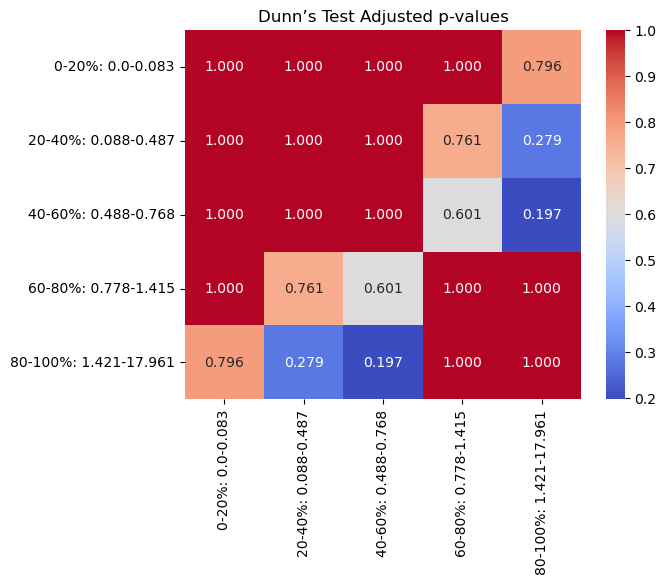

In [50]:
sns.heatmap(dunn_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Dunn’s Test Adjusted p-values")
plt.show()

In [59]:
# Run a Kruskal-Wallis test for each species
# Get list of all the species groups
grouped_data = [df[df['species'] == s]['piou'] for s in df['species'].unique()]
# Run Kruskal-Wallis test across all groups
stat, p = stats.kruskal(*grouped_data)
print(f"Kruskal-Wallis test: stat={stat:.3f}, p={p}")
if p < 0.05:
	print("Significant differences between groups (reject H0)")
else:
	print("No significant differences (fail to reject H0)")

Kruskal-Wallis test: stat=48.165, p=3.475637867896063e-11
Significant differences between groups (reject H0)


In [52]:
# Run Dunn's test for each species
dunn_df = sp.posthoc_dunn(df, val_col='piou', group_col='species', p_adjust='holm')
print(dunn_df)

                  pepper        tomato  watermelon
pepper      1.000000e+00  3.177382e-11    0.000025
tomato      3.177382e-11  1.000000e+00    0.158214
watermelon  2.496240e-05  1.582138e-01    1.000000


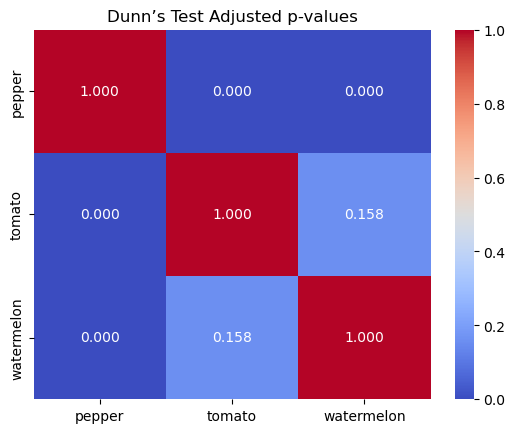

In [53]:
sns.heatmap(dunn_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Dunn’s Test Adjusted p-values")
plt.show()

In [57]:
# Run a Kruskal-Wallis test for each trial
# Get list of all the trial groups
grouped_data = [df[df['trial_dir'] == t]['piou'] for t in df['trial_dir'].unique()]
# Run Kruskal-Wallis test across all groups
stat, p = stats.kruskal(*grouped_data)
print(f"Kruskal-Wallis test: stat={stat:.3f}, p={p}")
if p < 0.05:
	print("Significant differences between groups (reject H0)")
else:
	print("No significant differences (fail to reject H0)")

Kruskal-Wallis test: stat=68.197, p=1.0380528388395246e-14
Significant differences between groups (reject H0)


In [58]:
# Run Dunn's test for each trial
dunn_df = sp.posthoc_dunn(df, val_col='piou', group_col='trial_dir', p_adjust='holm')
print(dunn_df)

                          Garden_Plots  Pepper_Variety_Trial  \
Garden_Plots              1.000000e+00          1.361948e-09   
Pepper_Variety_Trial      1.361948e-09          1.000000e+00   
Tomato_Fertilizer_Trial   5.767906e-01          2.106437e-11   
Watermelon_Variety_Trial  2.289367e-04          5.767906e-01   

                          Tomato_Fertilizer_Trial  Watermelon_Variety_Trial  
Garden_Plots                         5.767906e-01                  0.000229  
Pepper_Variety_Trial                 2.106437e-11                  0.576791  
Tomato_Fertilizer_Trial              1.000000e+00                  0.000031  
Watermelon_Variety_Trial             3.116873e-05                  1.000000  


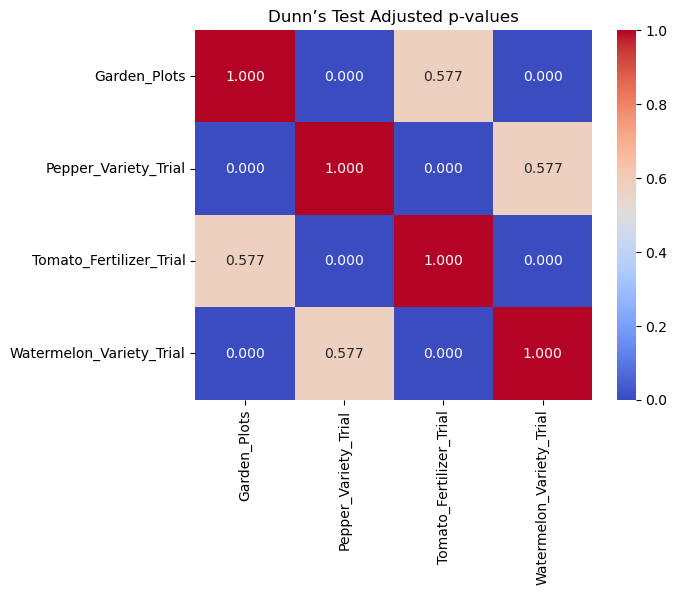

In [56]:
sns.heatmap(dunn_df, annot=True, cmap="coolwarm", fmt=".3f")
plt.title("Dunn’s Test Adjusted p-values")
plt.show()